In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

from gensim.models import Word2Vec, KeyedVectors
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
TOP_N_WORDS = 50
SIZE_DATA = 'all'
VECTOR_SIZE = 50

In [83]:
df = pd.read_csv(f'news_10_category_sa_{SIZE_DATA}.csv')
X = df['text']
y = df['category']

### Get the Most Common Words

In [84]:
all_words = [w for text in X for w in text.split()]
all_words_freq = pd.Series(all_words).value_counts()
all_words_freq

new             10721
photo            9294
one              9274
trump            8730
time             7784
                ...  
cotillion           1
winkwinking         1
nudgenudging        1
extorting           1
adjudged            1
Length: 76341, dtype: int64

In [85]:
percentage_list = []
count = 0
total = len(all_words)
for i in range(1, total):
    count += all_words_freq[i]
    percentage_list.append(count/total)
    if percentage_list[-1] > 0.9:
        print(f'the {i} words {all_words_freq.index[i]} that make up 90% of the corpus, the freq is {all_words_freq[i]}')
        break

the 10985 words whim that make up 90% of the corpus, the freq is 17


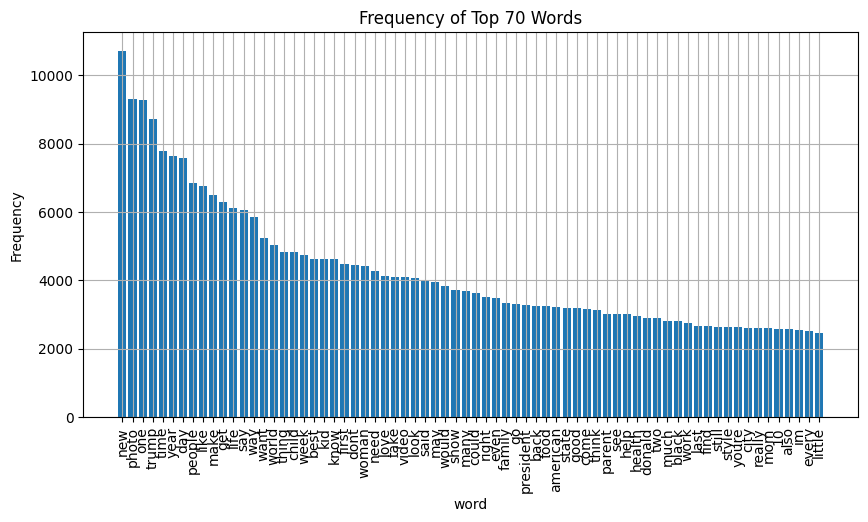

In [86]:
plt.figure(figsize=(10, 5))
plt.bar(all_words_freq.index[:70], all_words_freq.values[:70])
plt.xlabel('word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 70 Words')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [87]:
num = 60
print(f'Number of words appeared more than {num} times: {len(all_words_freq[all_words_freq >= num])}')
print(f"total number of words: {len(all_words_freq)}")

Number of words appeared more than 60 times: 4755
total number of words: 76341


In [88]:
num_to_keep = TOP_N_WORDS
top_words_to_keep = all_words_freq[:num_to_keep].index
def keep_word_in_list(text, top_words_to_keep):
    text = text.split()
    for t in text:
        if t in top_words_to_keep:
            continue
        else:
            text.remove(t)
    return ' '.join(text)
X_top_50 = X.apply(lambda x: keep_word_in_list(x, top_words_to_keep))
X_top_50.head()

0                    funniest cat week 1723 dont could
1    tweet parent week 1723 put toothpaste toothbru...
2    ricans fionas half people without water servic...
3    un russian affront charter house say president...
4    world captain want rainbow qatar come several ...
Name: text, dtype: object

In [45]:
def delete_word_in_list(text, word_to_delete_list):
    text = text.split()
    for t in text:
        if t in word_to_delete_list:
            text.remove(t)
    return ' '.join(text)
word_to_delete_list = all_words_freq[all_words_freq < num].index
#X_50 = X.apply(lambda x: delete_word_in_list(x, word_to_delete_list))
#X_50.head()

In [89]:
for i, text in enumerate(X_top_50):
    if len(text.split()) == 0:
        print(X_top_50.index[i])

In [90]:
top_words_to_keep

Index(['new', 'photo', 'one', 'trump', 'time', 'year', 'day', 'people', 'like',
       'make', 'get', 'life', 'say', 'way', 'want', 'world', 'thing', 'child',
       'week', 'best', 'kid', 'know', 'first', 'dont', 'woman', 'need', 'love',
       'take', 'video', 'look', 'said', 'may', 'would', 'show', 'many',
       'could', 'right', 'even', 'family', 'go', 'president', 'back', 'food',
       'american', 'state', 'good', 'come', 'think', 'parent', 'see'],
      dtype='object')

In [91]:
df_most_common = pd.DataFrame()
for word in top_words_to_keep:
    word_count = []
    for row in X_top_50:
        if word in row.split():
            word_count.append(1)
        else:
            word_count.append(0)
    df_most_common[word] = word_count
df_most_common.head()

,new,photo,one,trump,time,year,day,people,like,make,...,president,back,food,american,state,good,come,think,parent,see
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


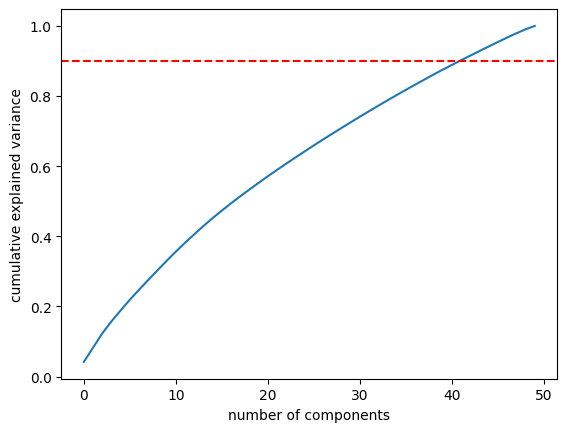

In [92]:
# reduce the dimension with PCA
# import TSNE
from sklearn.decomposition import PCA
pca = PCA().fit(df_most_common)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=.90, color = 'r', linestyle = '--') 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [93]:
cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
best_component = cumsum[(cumsum >= .90) & (cumsum  < .95)].dropna().index[0] 
print(f'\n total most common words: {len(df_most_common.columns)}')

print('Best Component that keep 90% info:', best_component)
print(f'\n total most common words after reduction: {best_component}')


 total most common words: 50
Best Component that keep 90% info: 41

 total most common words after reduction: 41


In [51]:
cumsum[-15:]

,0
35,0.817733
36,0.832404
37,0.846878
38,0.861200
39,0.875264
40,0.888830
41,0.902155
42,0.915378
43,0.928503
44,0.941456


### use best component

In [94]:
pca = PCA(n_components=best_component).fit(df_most_common)
features = pd.DataFrame(pca.transform(df_most_common))
new_X = pd.concat([X, features, y], axis=1)
new_X.head()

,text,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,category
0,23 funniest tweet cat dog week sept 1723 dog d...,-0.075016,-0.026230,-0.045559,-0.068516,-0.089618,-0.025181,-0.054830,-0.029275,-0.004688,...,-0.469828,0.202394,0.119284,0.745506,0.111101,-0.135652,-0.021035,-0.025474,-0.145460,ENTERTAINMENT
1,funniest tweet parent week sept 1723 accidenta...,0.016081,0.061104,-0.098545,-0.151645,-0.235822,0.250936,0.199719,0.359087,-0.581338,...,-0.047441,-0.043442,0.129088,0.037291,-0.024617,-0.005187,0.052319,0.003976,-0.015060,PARENTING
2,puerto ricans desperate water hurricane fionas...,-0.076034,0.169694,0.073387,-0.174724,-0.128420,-0.032900,0.137708,0.494282,1.073353,...,-0.077192,-0.015533,0.034831,-0.025161,-0.069183,-0.023562,0.013784,0.010392,-0.017827,WORLD NEWS
3,biden un call russian war affront body charter...,-0.200753,-0.195042,0.246008,0.081935,0.573224,-0.243680,0.652782,0.246699,-0.004664,...,0.019623,-0.005811,0.000769,0.002210,-0.041382,-0.034224,0.009002,0.017009,-0.015714,WORLD NEWS
4,world cup captain want wear rainbow armband qa...,-0.063070,0.078389,-0.064298,-0.073588,-0.148464,-0.020689,-0.026202,-0.107883,0.023847,...,0.017037,0.041122,0.231330,-0.342988,1.005568,0.172555,-0.206155,0.627217,0.168050,WORLD NEWS


In [95]:
new_X.to_csv(f'news_10_category_sa_{SIZE_DATA}_PCA_data.csv', index=False)

In [96]:
train, test = train_test_split(new_X, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)
print(f'Train set length: {len(train)} ; categories: {train["category"].nunique()}')
print(f'Val set length: {len(val)} ; categories: {val["category"].nunique()}')
print(f'Test set length: {len(test)} ; categories: {test["category"].nunique()}')

Train set length: 80960 ; categories: 10
Val set length: 10120 ; categories: 10
Test set length: 10120 ; categories: 10


In [97]:
def prepare_text_dict(all_words_freq):
    # the frequencies of words in text
    freq = all_words_freq
    clean_words = all_words_freq.index
        
    # vocabs set
    clean_words = set(clean_words)
    # convert words to indexes
    word2index = {w: i for i, w in enumerate(clean_words, 2)}  # start at 2
    word2index['<pad>'] = 1
    word2index['<unk>'] = 0

    # convert indexes to words
    index2word = {i: w for i, w in enumerate(clean_words, 2)}  # start at 2
    index2word[1] = '<pad>'
    index2word[0] = '<unk>'
    
    del freq, clean_words # just to save some RAM memory
    
    return word2index, index2word
# process text dict
text = pd.concat([train['text'], val['text']], axis=0)
word2index, index2word = prepare_text_dict(all_words_freq) # notice that we are won't use the 'test_set' vocabs

print('Total vocabs ', len(word2index))

Total vocabs  76343


In [98]:
# import labelencoder   
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
train['category'] = le.fit_transform(train['category'])
val['category'] = le.transform(val['category'])
test['category'] = le.transform(test['category'])

In [99]:
features_cols = new_X.columns[1:-1]
#features_cols

In [100]:
label2encoding = dict(zip(le.classes_, le.transform(le.classes_)))
encoding2label = dict(zip(le.transform(le.classes_), le.classes_))

In [101]:
class Data(Dataset):
    def __init__(self, df, word2index):
        self.word2index = word2index # to index text

        # sort text by length of total words
        df['length'] = df['text'].apply(lambda x: len(x.split()))
        df.sort_values(by='length', inplace=True)

        # prepare data
        self.target = df['category'].values
        self.text = df['text'].apply(lambda x: x.split()).values
        self.features = df.loc[:, features_cols].values

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):
        sequence = [self.word2index[w] for w in self.text[item] if w in self.word2index]
        features = self.features[item]
        target = self.target[item]

        return {'target': target, 'features': features, 'sequence': sequence}


def Bert_data(df):
    # sort text by length of words
    df['length'] = df['text'].apply(lambda x: len(x.split()))
    df.sort_values(by='length', inplace=True)

     # prepare data
    
    target = df['category'].values
    text = df['text'] # the BertTokenizer will index them so we don't need for word2index
    features = df.loc[:, features_cols].values

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    x_encoded = tokenizer.batch_encode_plus(text, pad_to_max_length=True)
    
    input_ids = torch.tensor(x_encoded['input_ids'],  device=device, dtype=torch.long)
    attention_mask = torch.tensor(x_encoded["attention_mask"],  device=device, dtype=torch.long) # to mark the text; if it was not a padding index,1 else 0
    #print(f'type of target: {type(target)}')
    target = torch.tensor(target,  device=device, dtype=torch.long)
    features = torch.tensor(features, device=device, dtype=torch.float)
    
    return TensorDataset(input_ids, attention_mask, features, target)

train_data = Data(train, word2index)
val_data = Data(val, word2index)
test_data = Data(test, word2index)

bert_train_data = Bert_data(train)
bert_val_data = Bert_data(val)
bert_test_data = Bert_data(test)

/Users/yaoyao/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [102]:
def pad_text(list_text, seq_length):
    paded_text = []
    for text in list_text:

        if len(text) == seq_length:
            paded_text.append(text)
        else:
            paded_text.append(text + (seq_length - len(text)) * [1]) # '1' is the index for 'PAD' in vocabs dict

    return paded_text


def collate_fn_padded(batch):
    target = [b['target'] for b in batch]
    features = [b['features'] for b in batch]
    sequence = [b['sequence'] for b in batch]

    # extract max_length
    max_length = max([len(b) for b in sequence])
    
    # pad text
    sequence = pad_text(sequence, max_length)

    # convert list to torch.tensor
    return {'target': torch.tensor(target, device=device, dtype=torch.long),
            'features': torch.tensor(features, device=device, dtype=torch.float),
            'sequence': torch.tensor(sequence, device=device, dtype=torch.long)
            }

In [103]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn_padded)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn_padded)

bert_train_loader = DataLoader(bert_train_data, batch_size=12)
bert_val_loader = DataLoader(bert_val_data, batch_size=12)
bert_test_loader = DataLoader(bert_test_data, batch_size=12)

In [104]:
vocab = word2index
word2vec_embeddings = {}
print('\nword2vec embeddings...')
# train a word2vec model on our text
all_words_lists = [[w for w in text.split()] for text in new_X['text'].values]
model = Word2Vec(sentences=all_words_lists, vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)
# save the model
model.save('word2vec.model')
# load the model
model = Word2Vec.load('word2vec.model')
# summarize vocabulary
words = list(model.wv.index_to_key)
for word in vocab.keys():
    if word in words:
        word2vec_embeddings[word] = model.wv[word]
    else:
        word2vec_embeddings[word] = np.zeros(VECTOR_SIZE)

missing = len(word2index) - len(word2vec_embeddings)
print(f'word2vec embeddings found for our vocabs: {len(word2vec_embeddings)} | missing: {missing} ; {missing / len(word2index) * 100:.1f}%')


word2vec embeddings...
word2vec embeddings found for our vocabs: 76343 | missing: 0 ; 0.0%


In [105]:

# create Look-Up table
def create_embedding_matrix(word_index, embedding_dict, dimension):
    embedding_matrix = np.zeros((len(vocab) + 1, dimension)) # (len_vocab, 100)

    for word, index in word_index.items():
        if word in embedding_dict.keys():
            embedding_matrix[index] = embedding_dict[word]

    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab, word2vec_embeddings, VECTOR_SIZE)

In [106]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, output_size, p=.5, use_features=False,
                 features_size=None):

        super().__init__()  # This is needed to initialize the nn.Module properly

        # 'use_features' if used, we supposed to give text and feature data to the model to make prediction.
        # create 'use_features' as 'self.use_features' so we can use it in the hole class functions(e.g. 'forward') instead of just in '__init__' attrbute
        self.use_features = use_features

        # 'Embedding' layer works like a lookup table(dictionary). The words are the keys in this table, while the dense word vectors are the values.
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM is the Long Short-Term Memory layer that will take the vectors represntations and extract the semantics/hidden_states
        self.LSTM = nn.LSTM(embedding_dim, hidden_size, num_layers=n_layers, bidirectional=False, batch_first=True, dropout=p)
        # if 'batch_first=True' 'hidden' shape will be (num_layers * num_directions, batch, hidden_size)
        # if 'batch_first=False' 'hidden' shape will be (num_layers * num_directions, seq_len, hidden_size)
        

        # A Dense/Linear layer that learn from last_hidden_state (optional layer; you can remove it)
        self.Linear = nn.Linear(hidden_size, hidden_size)

        # Dropout layer that help regularizing and prevent overfitting (optional layer)
        # It randomly zeroes some of the elements of the input tensor with probability 'p'
        self.Dropout = nn.Dropout(p)

        # Dense/Linear layer to predict the class of the text/sequence
        self.output = nn.Linear(hidden_size, output_size)

        # add these layers if 'use_features'
        if self.use_features:
            # this dense layer will take the features and tune its parameters
            self.f_Linear = nn.Linear(features_size, hidden_size)

            # this dense layer will take the output from 'f_Linear' and predict the class of the text/sequence
            self.f_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, features=None):  # run the network

        Embedding = self.Embedding(x)  # map the words to their vectors representations by the Embedding layer

        output, (hidden, cell) = self.LSTM(Embedding)  # calculate the sequence/text sementics
        # 'output' comprises all the hidden states in the last layer
        # (hidden, cell) comprises the hidden states after the last timestep

        # 'cell' state contains info about wether to keep a hidden state or no (num_layers * num_directions, batch, hidden_size)
        # 'output' state is a tensor of all the 'hidden' states from each time step  (seq_len, batch, num_directions * hidden_size)
        # 'hidden' state is the hidden states from the last time step  (num_layers * num_directions, batch, hidden_size) 

        last_hidden_state = hidden[-1, :, :]  # last hidden state from the last time step (seq_len, hidden_size)

        x = nn.functional.leaky_relu(self.Linear(last_hidden_state), .001)
        # 'leaky_relu' is similar to relu activation function, it just let the values to be between '0.001' and any other number

        x = self.Dropout(x)  # apply dropout

        # combine the outputs of text and features if 'use_features' is 'True'.
        # we will multiply each output by 0.5 to get half the original weights, and then combine the two halves
        # to have a predictions from both outputs weights.
        if self.use_features:

            x = self.output(x) * 0.5  # half the weights

            x_2 = nn.functional.leaky_relu(self.f_Linear(features), .001)
            x_2 = self.f_output(x_2) * 0.5  # half the weights

            final_x = x + x_2  # combine the two halves outputs

            return final_x

        else:
            return self.output(x)  # if 'use_features' is 'False' then 'features' output won't be calculated


In [107]:
class CNN_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_filters, filter_sizes, output_size, p=.5, use_features=False,
                 features_size=None):
        super().__init__()
        self.use_features = use_features
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)

        # we will build 'Conv2d' layers as much as the amount of 'filter_sizes' list
        # the 'kernel_size' will be (filter_size, embedding_dim),
        # 'filter_size' is the number words to take as 'n-gram'
        # 'embedding_dim' is the vector representation for the word (Embedding dimentions)
        # 'ModuleList' helps in creating more then one layer at once
        print(filter_sizes)
        self.convs = nn.ModuleList(nn.Conv2d(1, n_filters, (ks, embedding_dim)) for ks in filter_sizes)  # 'convs' will be as much as 'filter_sizes' list

        # note: There is no hidden layer between 'convs' layers and 'output' layer


        # we will concatenate all 'convs' layers outputs and feed them to the 'output' layer
        self.output = nn.Linear(len(filter_sizes) * n_filters, output_size)

        self.Dropout = nn.Dropout(p)

        if self.use_features:
            self.f_Linear = nn.Linear(features_size, hidden_size)
            self.f_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, features=None):
        # the 'Conv2d layer' wants inputs of shape (batch, Channel, Height, Width)
        # our text is of shape(batch, seq_lens)

        # after feeding text to the 'Embedding' layer, we will have shape(batch, seq_lens, embedding_dim)
        Embedding = self.Embedding(x)

        # the convolutional layer wants the inputs to be of
        # shape(batch,  Channel, Height, Width) and the 'Embedding' layer's output is shape(batch, seq_lens, embedding_dim)
        # to make 'Embedding' output correct to feed a 'convs' layer, its shape must be same as the shape of a conv layer.

        # the batch in conv shape exist in 'Embedding' shape.
        # the Channel in conv shape will be the number of embedding layers; in our case it's 1 'Embedding' layer.
        # the Height in conv shape  will be the 'seq_lens'(num words or n-gram)
        # the Width in conv shape  will be the 'embedding_dim'(vector representation of a word)

        # conv(batch, Channel, Height, Width) = Embedding(batch, num_embeddings, seq_lens, embedding_dim)
        Embedding = Embedding.unsqueeze(1) # create Channel dimension

        convs = [F.relu(c(Embedding)).squeeze(3) for c in self.convs]
        # after applying a conv layer, the output will be of shape (batch, Height, Width, Channel)
        # the 'max_pool1d' layer doesn't want the channel dimension(third dim), so we will remove/squeeze it by using .squeeze(3)

        convs = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in convs]
        # the kernel_size is the word embedding_dim (c.shape[2]; which is the Width dimension(second dim) ).
        # since the Width dimension (c.shape[2]) is pooled, the second dimension is empty.
        # so we will remove/squeeze it by using .squeeze(2)

        # we will concatenate all 'convs' outputs (note that 'convs' is a list of all 'convs' layers
        # outputs; e.g. [conv1, conv2, ...])

        # the shape is, 'batch_size' and the sum of all the filters of all 'convs'
        # layers (e.g. n_filter1 + n_filter2 ..., depending on how many conv layer there)
        total_pools = torch.cat(convs, dim=1)  # (batch, total_filters)

        x = self.Dropout(total_pools)

        if self.use_features:
            x = self.output(x) * 0.5
            x_2 = nn.functional.leaky_relu(self.f_Linear(features), .001)
            x_2 = self.f_output(x_2) * 0.5
            final_x = x + x_2
            return final_x
        else:
            return self.output(x)


# We have to build a function that pad tha sequences that are less then the filter size
# The model will throw an error if a sentence/sequence is less then the kernel_size of certain conv, so we must pad it
# to the maximum size of kernel_size.
def cnn_padding_to_match_filtersize(text, filter_sizes):
    features_ = []
    for f in text:
        f = f.cpu().numpy().tolist()
        if len(f) < max(filter_sizes):
            f += [1] * (max(filter_sizes) - len(f))
            features_.append(f)
        else:
            features_.append(f)

    return torch.LongTensor(features_).to(device)


In [108]:
def train_func(model, optimizer, criterion, iterator, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []
    
    model.train() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator: # loop over the whole data batch-by-batch
        optimizer.zero_grad()
        text = batch['sequence']
        features = batch['features']
        label = batch['target']
        if type(model).__name__ == 'CNN_Model':  # for CNN training
            # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
            # a conv layer kernel size is (kernel_size, embedding_dim), so we must pad short texts to the maximum size of filter_sizes list
            # we will do this using the function we created before (in CNN archeticture).

            filter_sizes = [2, 3, 5, 7]
            if using_features:
                output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
            else:
                output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

        else:  # for other models
            if using_features:
                output = model(text, features)
            else:
                output = model(text)
                
        loss = criterion(output, label) # calcualte loss function
        loss.backward() # backprobgate loss function

        # Gradient clipping is a technique that tackles exploding gradients. 
        # The idea of gradient clipping is very simple: If the gradient gets too large, we rescale it to keep it small.
        nn.utils.clip_grad_norm_(model.parameters(), 1) # optinal 
        
        # calculate optimizer
        optimizer.step()

        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)

    return loss, f1, accuracy

In [109]:
def eval_func(model, criterion, iterator, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []

    model.eval() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator:# loop over the whole data batch-by-batch
        # PREPARE DATA
        text = batch['sequence']
        features = batch['features']
        label = batch['target']
            
        # FEED MODEL
        
        with torch.no_grad(): # don't  calculate  gradients
            if type(model).__name__ == 'CNN_Model':  # for CNN model
                # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
                # conv layer kernel size is of shape(kernel_size, embedding_dim), so we must pad short texts to the maximum size filter_sizes
                # we will do this using the function we created before (in CNN archeticture).
                filter_sizes = [2, 3, 5, 7]
                if using_features: 
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
                else:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

            else:  # for other models
                if using_features:
                    output = model(text, features)
                else:
                    output = model(text)

            loss = criterion(output, label) # calcualte loss function

        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)

    return loss, f1, accuracy

In [110]:
# --- pred loop --- #
def pred(model, iterator, loss_function, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []

    model.eval() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator:# loop over the whole data batch-by-batch
        # PREPARE DATA 
        # extract non-BERT data if the current model is not BERT
        text = batch['sequence']
        features = batch['features']
        label = batch['target']

        # FEED DATA
        with torch.no_grad(): # don't calculate gradients
            if type(model).__name__ == 'CNN_Model':  # for CNN model
                # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
                # conv layer kernel size is of shape(kernel_size, embedding_dim), so we must pad short texts to the maximum size filter_sizes
                # we will do this using the function we created before (in CNN archeticture).
                
                filter_sizes = [2, 3, 5, 7]
                if using_features:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
                else:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

            else:  # for other models
                if using_features:
                    output = model(text, features)
                else:
                    output = model(text)

            loss = loss_function(output, label) # calcualte loss function
        
        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    name = type(model).__name__ # the name of the Model

    return loss, f1, accuracy, name

In [111]:
def training_model(model, optimizer, criterion, train_iterator, eval_iterator, epochs=1000, using_features=False):
    print('\nTraining Started...\n')
    # for early stopping
    stop = 0  # increase this number if the model didn't become more accurate compared to the last best epoch
    min_eval_acc = 0. # assign this number as the best evaluation accuracy score

    for epoch in range(epochs): # Epochs Loop 
    
        loss, f1, acc = train_func(model, optimizer, criterion, train_iterator, using_features)  # train model
        eval_loss, eval_f1, eval_acc = eval_func(model, criterion, eval_iterator, using_features)  # evaluate model


        # save current-epoch model file, so we can coninue training later (fine-tuning the paremeters of last epoch). and delete
        # the previous current-epoch model file, to avoid making lots of files(you can delete this section if you want)
        # best model scores
        if eval_acc > min_eval_acc: # current accuracy greater then the best accuracy 
            min_eval_acc = eval_acc # assign 'min_eval_acc' as the best accuracy
            #training scores
            best_loss = loss
            best_acc = acc
            best_f1 = f1
            
            #evaluation scores
            best_eval_loss = eval_loss
            best_eval_acc = eval_acc
            best_eval_f1 = eval_f1

            best_model = model.state_dict() # best model parameters
            best_epoch = epoch + 1  # '+ 1' because 'epoch' starts from 0
            stop = 0 # reset 'stop' counter
            # print the current as the 'Best Epoch score'
            print(
                f'BEST Epoch({best_epoch} | Train(loss: {best_loss} | acc: {best_acc} | f1-score: {best_f1}) & Eval(loss: {best_eval_loss} | acc: {best_eval_acc} | f1-score: {best_eval_f1})\n')
            return best_model, best_epoch, best_loss, best_acc, best_f1, best_eval_loss, best_eval_acc, best_eval_f1

        # if current accuracy wasn't greater then the best accuracy add 1 to 'stop'
        else:
            stop += 1
            # print the current epoch as the 'Normal Epoch score'
            print(
                f'Epoch({epoch + 1} | Train(loss: {loss} | acc: {acc} | f1-score: {f1}) & Eval(loss: {eval_loss} | acc: {eval_acc} | f1-score: {eval_f1})\n')
        
        # if 'stop' reached 5 it will stop training
        if stop == 5:
            print('EARLY STOPPING!')
            # print the best epoch recorded during the whole training
            print(
                f'BEST EPOCH({best_epoch} | Train(loss:{best_loss} | acc:{best_acc} | f1-score:{best_f1}) & Eval(loss: {best_eval_loss} | acc: {best_eval_acc} | f1-score: {best_eval_f1})\n')
            return best_model, best_epoch, best_loss, best_acc, best_f1, best_eval_loss, best_eval_acc, best_eval_f1
            # save best model
            # torch.save(best_model, f'epoch_{best_epoch}_val_loss_{best_eval_loss}_val_acc_{best_eval_acc}_val_f1_{best_eval_f1}.pt')
            break

In [112]:
vocab_size = len(word2index)
embedding_dim = 50
output_size = len(le.classes_)

hidden_size = 64
filter_sizes = [2, 3, 5, 7]
n_filters = 64
n_layers = 2
filter_sizes = [2, 3, 5, 7]
print('Size Of Vocab: ', vocab_size)


model_lstm = LSTM_Model(vocab_size, embedding_dim, hidden_size, n_layers, output_size)

model_cnn = CNN_Model(vocab_size, embedding_dim, hidden_size, n_filters, filter_sizes, output_size)
models = [model_cnn, model_lstm]



Size Of Vocab:  76343
[2, 3, 5, 7]


In [113]:
# import Adam optimizer
from torch.optim import AdamW
import torch.nn.functional as F

In [121]:
loss_function = nn.CrossEntropyLoss().to(device)
best_model_list = []
def count_parameters(model):
    # to know how many parametres a 'trained' model has  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
for clf in models:
    print('----------------------')
    print('----------------------')
    print('model Name: ', type(clf).__name__) # print Model Name
    print(f'{type(clf).__name__} has {count_parameters(clf):,} trainable parameters') # print Model Total Parameters 
    clf = clf.to(device) # convert model to GPU memory for fast training
    # use flexible learning rate
    
    optimizer = AdamW(clf.parameters(), lr= 0.00001, weight_decay=0.0001) # assign AdamW as optimizer
    
    best_model_list.append([training_model(clf, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)]) 

----------------------
----------------------
model Name:  CNN_Model
CNN_Model has 3,874,376 trainable parameters

Training Started...

BEST Epoch(1 | Train(loss: 0.7671 | acc: 76.9 | f1-score: 71.0) & Eval(loss: 0.9816 | acc: 72.2 | f1-score: 65.5)

----------------------
----------------------
model Name:  LSTM_Model
LSTM_Model has 3,884,936 trainable parameters

Training Started...

BEST Epoch(1 | Train(loss: 0.6262 | acc: 82.1 | f1-score: 77.1) & Eval(loss: 0.8828 | acc: 74.5 | f1-score: 68.0)



#### result
2k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 17.3
CNN, 42.4

6k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 29.5
CNN, 45.5

10k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 57.1
CNN, 59.6

30k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 66.9
CNN, 62.7

All - Top_50_VecSize50, learning_rate-0.01, weight_decay-0.1
LSTM, 69.7
CNN, 62.6

All - Top_50_VecSize50, learning_rate-0.1, weight_decay-0.01
LSTM, 10.9
CNN, 8.9

All - Top_50_VecSize50, learning_rate-0.01, weight_decay-0.01
LSTM, 58.4 68.5
CNN, 58.3 62.1

All - Top_50_VecSize50, learning_rate-0.001, weight_decay-0.01
LSTM, 73.1
CNN, 69.7

In [73]:
best_model_list

[[(OrderedDict([('Embedding.weight',
                 tensor([[-0.0743, -0.5552,  0.8950,  ...,  0.2901,  0.1631, -0.8590],
                         [-0.4971,  0.4337, -0.4693,  ..., -0.8134,  1.5740,  0.4124],
                         [-0.9304, -0.1974,  0.0628,  ...,  0.1839,  1.5215, -0.2789],
                         ...,
                         [-0.3207, -0.0592, -0.9811,  ...,  0.7449, -1.0407,  0.2015],
                         [ 0.1694, -0.6226, -0.5921,  ...,  0.7865,  1.0598,  0.4355],
                         [ 0.6457, -0.7880, -1.0247,  ...,  0.1789, -1.4888,  0.1691]])),
                ('convs.0.weight',
                 tensor([[[[-0.2521,  0.1675, -0.0112,  ...,  0.2689,  0.0873, -0.0026],
                           [-0.1326, -0.0042,  0.1200,  ...,  0.4136, -0.1625, -0.1724]]],
                 
                 
                         [[[ 0.1933,  0.0938,  0.1641,  ...,  0.2596,  0.4600,  0.1791],
                           [ 0.2300, -0.0647,  0.1637,  ..., -0.0450

In [74]:
vectorizer = TfidfVectorizer()
# transform the text into a vector
X_vec = vectorizer.fit_transform(X)

In [75]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_vec_std = scaler.fit_transform(X_vec)

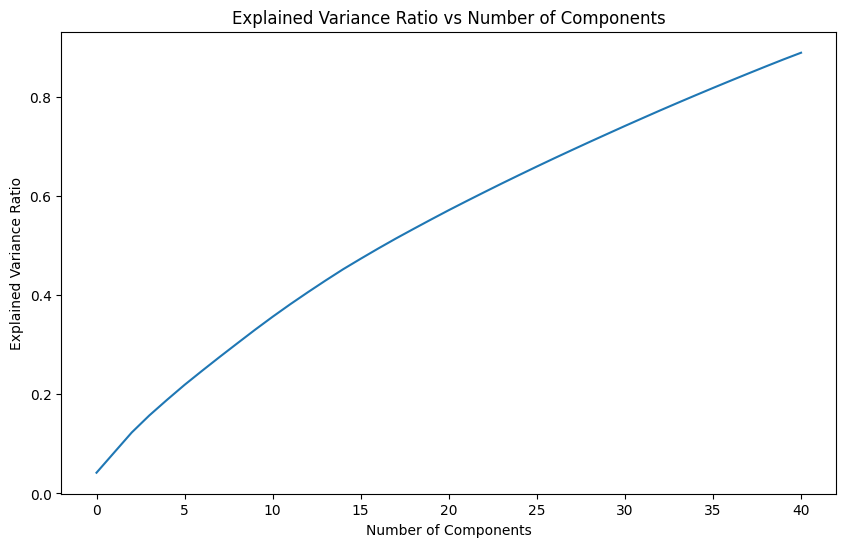

In [76]:
# plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.show()

cumulative explained variance values: 
           0
0   0.041729
1   0.082360
2   0.122882
3   0.157319
4   0.188627
5   0.218957
6   0.247477
7   0.275477
8   0.302876
9   0.330067
10  0.356332
11  0.381554
12  0.405771
13  0.429306
14  0.452103
15  0.473326
16  0.494065
17  0.514150
18  0.533494
19  0.552542
20  0.571264
21  0.589410
22  0.607282
23  0.624929
24  0.642216
25  0.659318
26  0.676139
27  0.692646
28  0.708996
29  0.725079
30  0.741122
31  0.756833
32  0.772471
33  0.787762
34  0.802844
35  0.817733
36  0.832404
37  0.846878
38  0.861200
39  0.875264
40  0.888830


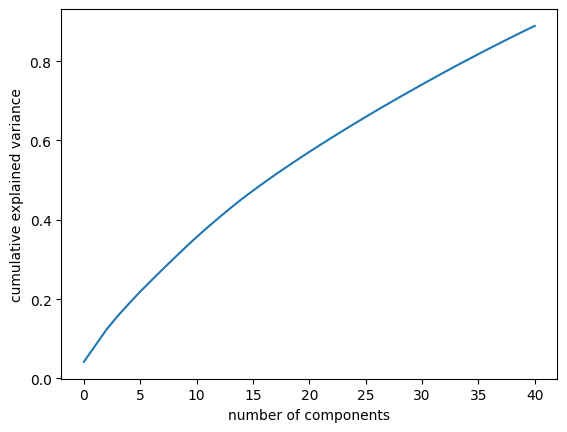

In [77]:
# plot PCA explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.axhline(y=.90, color = 'r', linestyle = '--') 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# create dataframe of explained_variance_ratio_ values
cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
print('cumulative explained variance values: ')
print(cumsum)